## Dogs vs. Cats

### パッケージ群のインポート

In [0]:
import tensorflow
from tensorflow import keras
%matplotlib inline
import matplotlib.pyplot as plt

import os, cv2, random
import numpy as np
import pandas as pd

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import preprocess_input
from PIL import Image

Using TensorFlow backend.


## kaggleデータセットのインポート

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"norihisa","key":"d016ea67c3249f44d2090f6c16a2ade1"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!pip install kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c dogs-vs-cats

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip train.zip

Archive:  train.zip
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!unzip test1.zip

Archive:  test1.zip
replace test1/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## トレーニング・テストデータの作成

In [0]:
train_dir = '/content/train'
val_dir = '/content/test1'

In [0]:
ls -l /content/train/1_dog/ | tail

-rw-r--r-- 1 root root 18105 Sep 20  2013 dog.9993.jpg
-rw-r--r-- 1 root root 22017 Sep 20  2013 dog.9994.jpg
-rw-r--r-- 1 root root  4945 Sep 20  2013 dog.9995.jpg
-rw-r--r-- 1 root root 14786 Sep 20  2013 dog.9996.jpg
-rw-r--r-- 1 root root 47043 Sep 20  2013 dog.9997.jpg
-rw-r--r-- 1 root root 35711 Sep 20  2013 dog.9998.jpg
-rw-r--r-- 1 root root  3339 Sep 20  2013 dog.9999.jpg
-rw-r--r-- 1 root root 28899 Sep 20  2013 dog.999.jpg
-rw-r--r-- 1 root root 34392 Sep 20  2013 dog.99.jpg
-rw-r--r-- 1 root root 28733 Sep 20  2013 dog.9.jpg


In [0]:
!mkdir /content/train/0_cat
!mkdir /content/train/1_dog

In [0]:
!mkdir /content/test1/0_cat
!mkdir /content/test1/1_dog

In [0]:
!mv /content/train/cat* /content/train/0_cat/.

In [0]:
!mv /content/train/dog* /content/train/1_dog/.

In [0]:
!mv /content/train/0_cat/cat.9* /content/test1/0_cat/.

In [0]:
!mv /content/train/1_dog/dog.9* /content/test1/1_dog/.

In [0]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (224, 224, 3))

In [0]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range=50,
    horizontal_flip=True,
    )

validationgen = ImageDataGenerator(
    rescale=1./255,
    )

In [0]:
train_generator = datagen.flow_from_directory(
  train_dir,
  target_size=(224,224),
  batch_size = 32,
  class_mode = 'categorical')

validation_generator = validationgen.flow_from_directory(
  val_dir,
  target_size=(224,224),
  batch_size = 32,
  class_mode = 'categorical')

Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.


In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models
model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
__________________________________

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False    

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=1e-5, decay=1e-6),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [0]:
history = model.fit_generator(train_generator,steps_per_epoch=7,
                              validation_data=validation_generator,
                              validation_steps=5,
                              epochs = 50)

Epoch 1/50
7/7 [==============================] - 7s 931ms/step - loss: 0.9848 - acc: 0.5089 - val_loss: 0.6539 - val_acc: 0.6250
Epoch 2/50
7/7 [==============================] - 4s 638ms/step - loss: 0.8170 - acc: 0.5714 - val_loss: 0.6139 - val_acc: 0.6875
Epoch 3/50
7/7 [==============================] - 5s 656ms/step - loss: 0.7666 - acc: 0.5893 - val_loss: 0.5768 - val_acc: 0.7312
Epoch 4/50
7/7 [==============================] - 5s 647ms/step - loss: 0.7963 - acc: 0.6027 - val_loss: 0.5593 - val_acc: 0.7625
Epoch 5/50
7/7 [==============================] - 5s 648ms/step - loss: 0.7270 - acc: 0.5982 - val_loss: 0.5428 - val_acc: 0.7375
Epoch 6/50
7/7 [==============================] - 5s 665ms/step - loss: 0.7062 - acc: 0.5893 - val_loss: 0.5042 - val_acc: 0.8562
Epoch 7/50
7/7 [==============================] - 4s 627ms/step - loss: 0.7954 - acc: 0.5179 - val_loss: 0.4829 - val_acc: 0.8125
Epoch 8/50
7/7 [==============================] - 5s 664ms/step - loss: 0.6739 - acc: 0.62

In [0]:
model.save('model.hdf5')

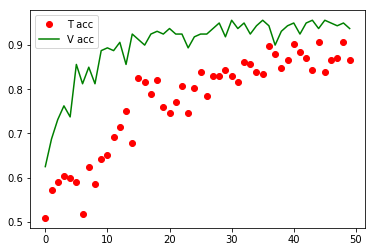

In [0]:
# 精度の履歴を可視化する。
ha = history.history['acc']
va = history.history['val_acc']
epochs = range(len(ha))
plt.plot(epochs, ha, 'ro', label='T acc')
plt.plot(epochs, va, 'g', label='V acc')
plt.legend();

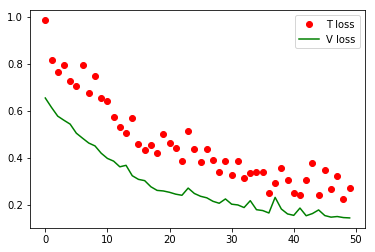

In [0]:
# 損失関数の履歴を可視化する。
ha = history.history['loss']
va = history.history['val_loss']
epochs = range(len(ha))
plt.plot(epochs, ha, 'ro', label='T loss')
plt.plot(epochs, va, 'g', label='V loss')
plt.legend();

In [0]:
# 評価
test_loss, test_acc = model.evaluate_generator(validation_generator)
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2%}")

test loss: 0.65, test accuracy: 70.43%


In [0]:
# 推論する
class_names = list(validation_generator.class_indices.keys())

def plot_prediction(img, prediction, label):
    pred_label = np.argmax(prediction)

    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5), facecolor="w")

    ax1.imshow(img)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel(
        f"{class_names[pred_label]} {prediction[pred_label]:.2%} ({class_names[label]})",
        fontsize=15,
    )

    bar_xs = np.arange(len(class_names))  # 棒の位置
    ax2.bar(bar_xs, prediction)
    ax2.set_xticks(bar_xs)
    ax2.set_xticklabels(class_names, rotation="vertical", fontsize=15)

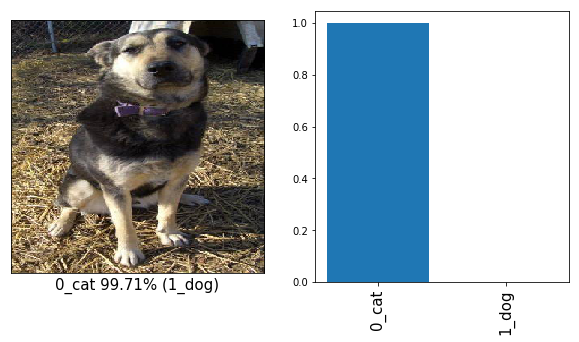

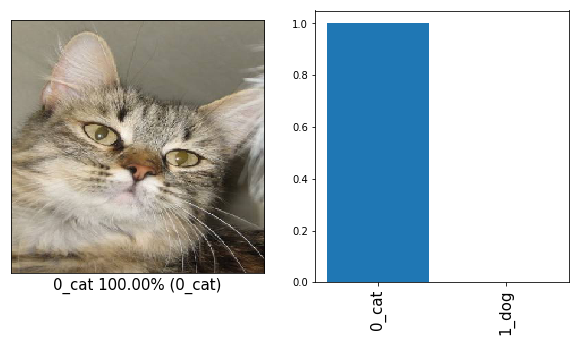

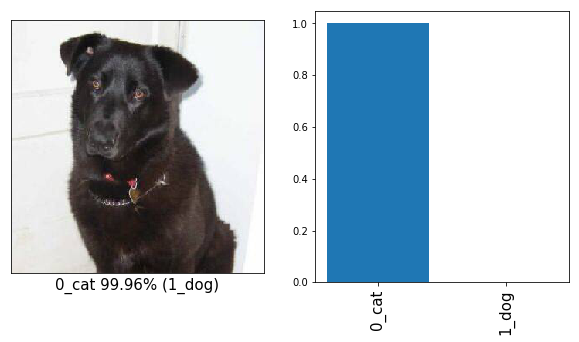

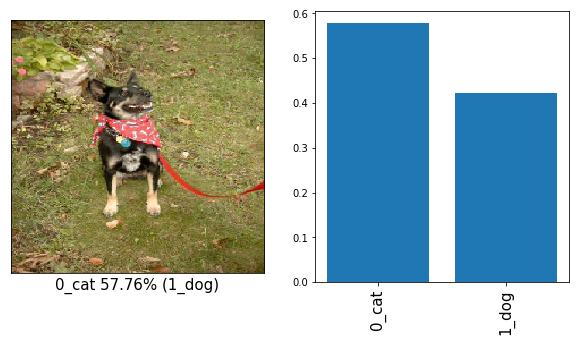

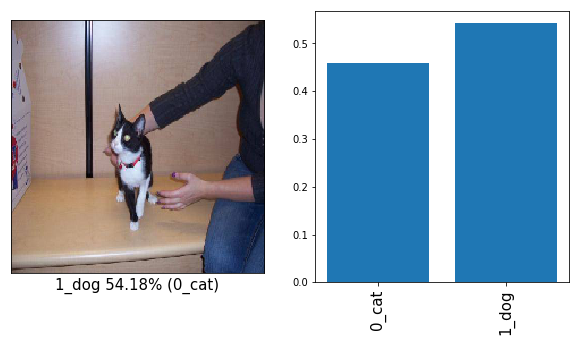

In [0]:
# バリデーションデータから3サンプル推論して、結果を表示する。
for i in validation_generator.index_array[0:5]:
    img_path = validation_generator.filepaths[i]
    label = validation_generator.labels[i]

    # 画像を読み込む。
    img = Image.open(img_path)
    # モデルの入力サイズにリサイズする。
    img = img.resize(reversed(validation_generator.target_size))
    # PIL -> numpy 配列
    img = np.array(img)
    # バッチ次元を追加する。
    x = np.expand_dims(img, axis=0)
    # 前処理を行う。
    x = preprocess_input(x)

    # 推論する。
    prediction = model.predict(x)

    # 推論結果を可視化する。
    plot_prediction(img, prediction[0], label)